In [26]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Bring in data

In [27]:
df_raw = pd.read_csv('data/missoula_valley_monitored_wells.csv', parse_dates=['time'], index_col='time')
df_filled = pd.read_csv('data/missoula_valley_wells_imputed_qreg.csv')
df_static = pd.read_csv('data/static_variables.csv')
df_dyn = pd.read_csv('data/dynamic_variables_norm.csv', index_col=0, parse_dates=True)

In [28]:
# Multiply depths by -1
df_raw = -df_raw
depth_cols = [i for i in df_filled.columns if not i in ['time', 'Q']]
for col in depth_cols:
    df_filled[col] *= -1
    

### Heatmap of all data and gaps

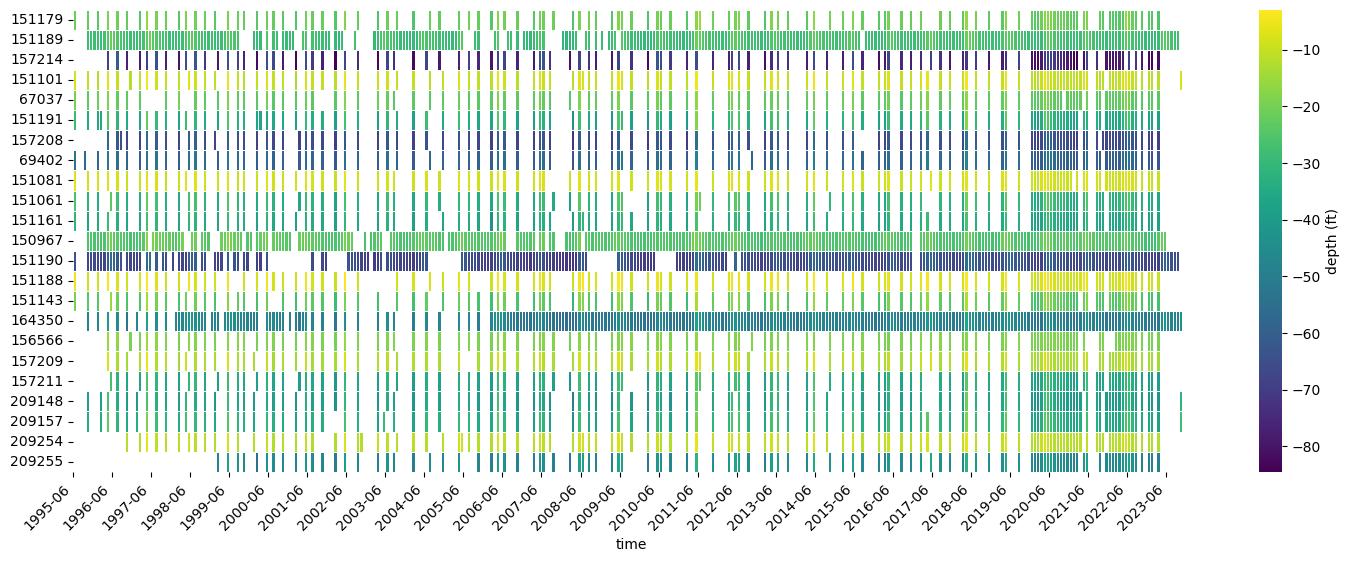

In [29]:
fig, ax = plt.subplots(figsize=(18, 6))
fig = sns.heatmap(df_raw.transpose(), 
                  cmap='viridis', 
                  cbar=True, 
                  linewidth=0.5, 
                  ax=ax, 
                  cbar_kws={'label': 'depth (ft)'})
xdates = df_raw.index.strftime('%Y-%m').sort_values().unique()
step = 12
ax.set_xticks(np.arange(0, len(xdates), step=step))
ax.set_xticklabels(xdates[::step], rotation=45, ha='right')
plt.show()

### Plot timeseries of all wells

In [30]:
df_melt = df_filled.dropna().drop(columns='Q').melt(id_vars='time')
# df_melt = df_filled.drop(columns='Q').melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])

In [31]:
# Calculate trends and p-values and add to the DataFrame
df_trend = df_melt.copy()
df_trend['time'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)
def get_trend(x):
    """Define a function to fit a linear regression model and return the slope, 
    intercept, and p-value."""
    model = smf.ols('value ~ time', data=x).fit()
    return pd.Series([model.params['Intercept'], 
                      model.params['time'], 
                      model.pvalues['time']], 
                     index=['intercept', 'slope', 'p-value'])

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(get_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

In [32]:
# Define a function to plot the data and the trendline
def plot_data_and_trendline(data, color):
    x = data['time']
    y = data['value']
    slope = data['slope'].iloc[0]
    intercept = data['intercept'].iloc[0]
    p_value = data['p-value'].iloc[0]
    
    # Convert the 'time' column to datetime for plotting
    x_datetime = pd.to_datetime(x, unit='s')
    
    # Plot the data
    plt.plot(x_datetime, y, color='gray', linewidth=0.75)
    
    # Set the color of the trendline based on the p-value
    trend_color = 'red' if p_value < 0.1 else 'black'

    # Add the p-value to the plot
    plt.text(0.15, 0.9, f'p-value: {p_value:.2f}', ha='left', va='top', transform=plt.gca().transAxes)

    # Plot the trendline
    plt.plot(x_datetime, intercept + slope * x, color=trend_color)

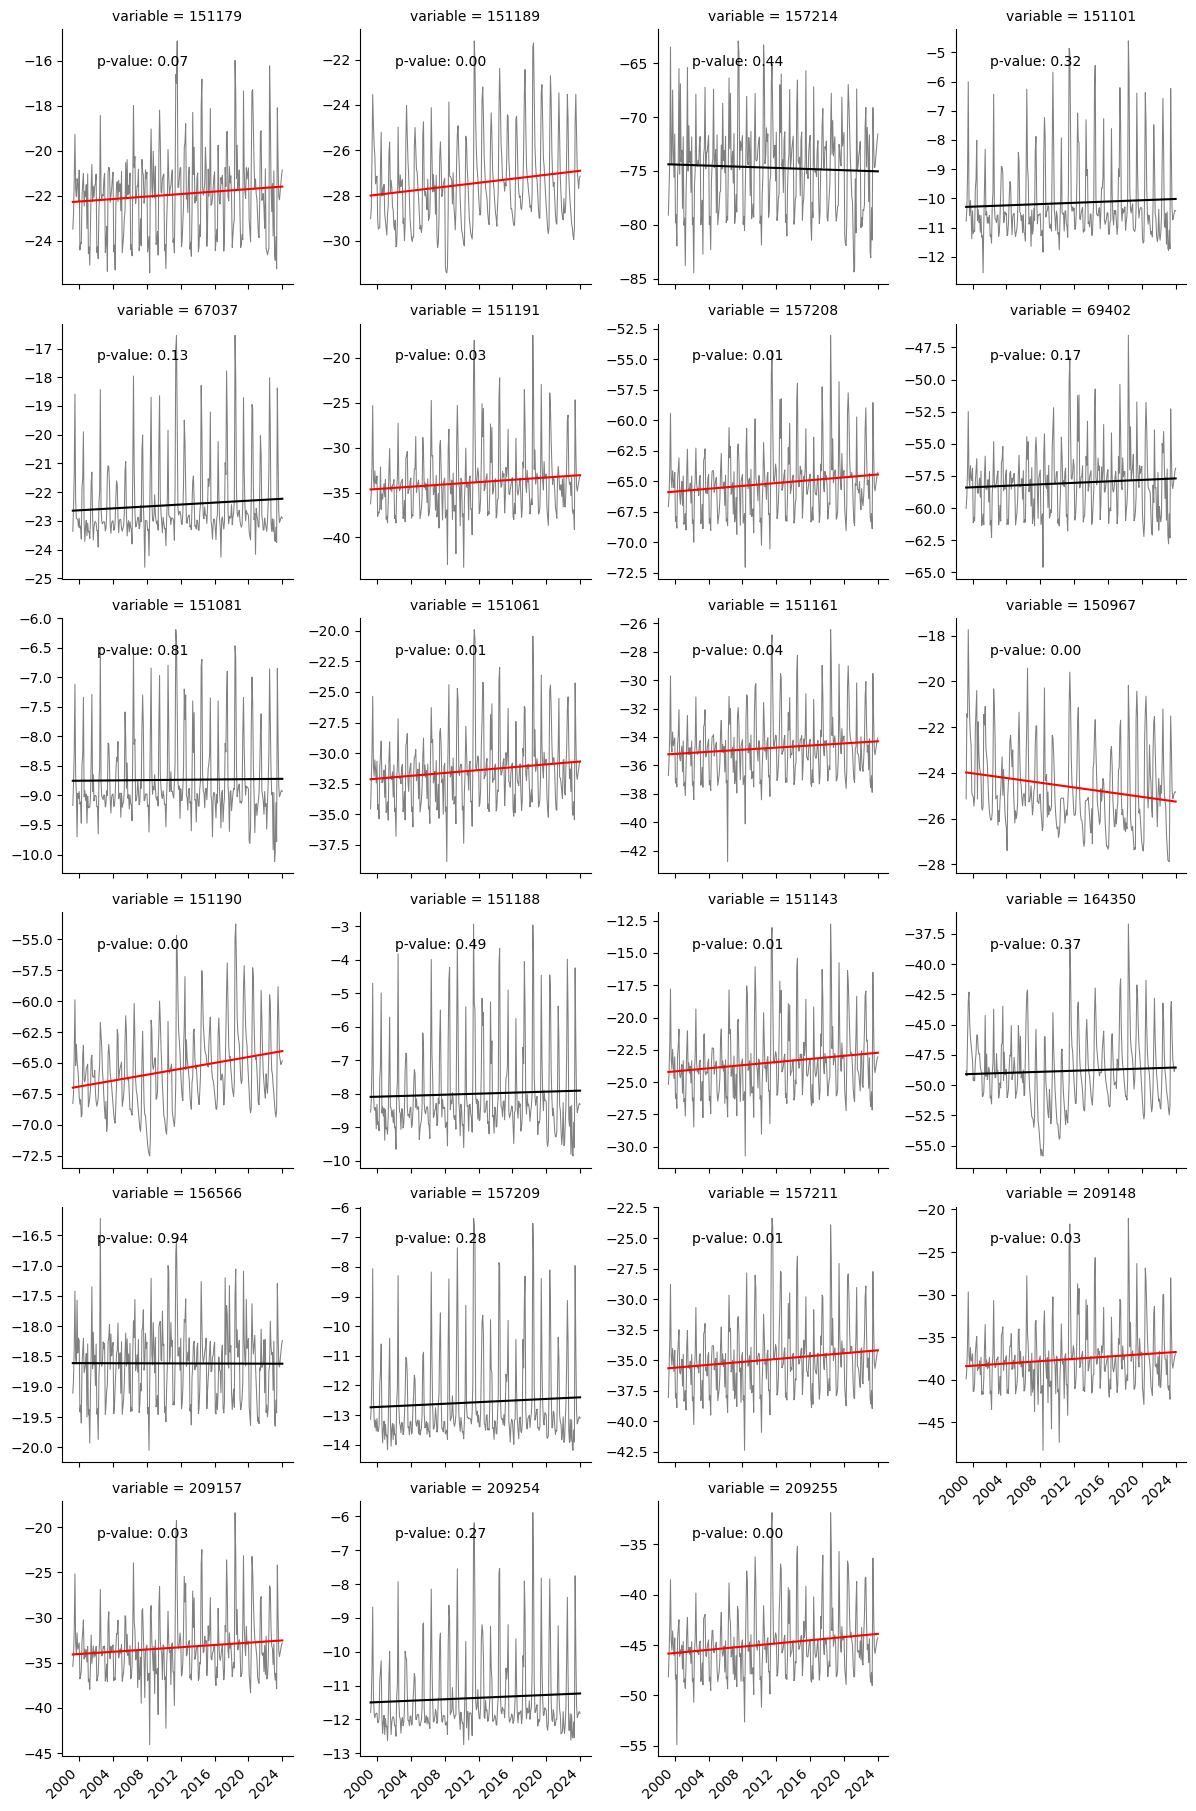

In [33]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(plot_data_and_trendline)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

### Trends in interannual variability over time

In [34]:
# Define a function to calculate and plot the data and the quantile regression lines 
def plot_data_and_quantreg(data, color, quants=[0.1, 0.9], plot=True):
    data = data.dropna()
    x = np.arange(len(data['time'])) 
    y = data['value']
    data_df = pd.DataFrame({'x': x, 'y': y})
    
    # Quantile regresssion
    model = smf.quantreg('y ~ x', data_df)
    q1 = model.fit(q=quants[0])
    q2 = model.fit(q=quants[1])
    q3 = model.fit(q=0.5)
    
    # Convert the 'time' column to datetime for plotting
    x_datetime = pd.to_datetime(data['time'], unit='s')
    
    if plot:
        # Plot the data
        plt.plot(x_datetime, y, color='gray', linewidth=0.75)
        
        # Plot the quantile regression lines
        plt.plot(x_datetime, q1.fittedvalues, color='red')
        plt.plot(x_datetime, q2.fittedvalues, color='red')
        plt.plot(x_datetime, q3.fittedvalues, '--', color='black')
    else:
        return q1, q2, q3

/home/nick/miniforge3/envs/hydro/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


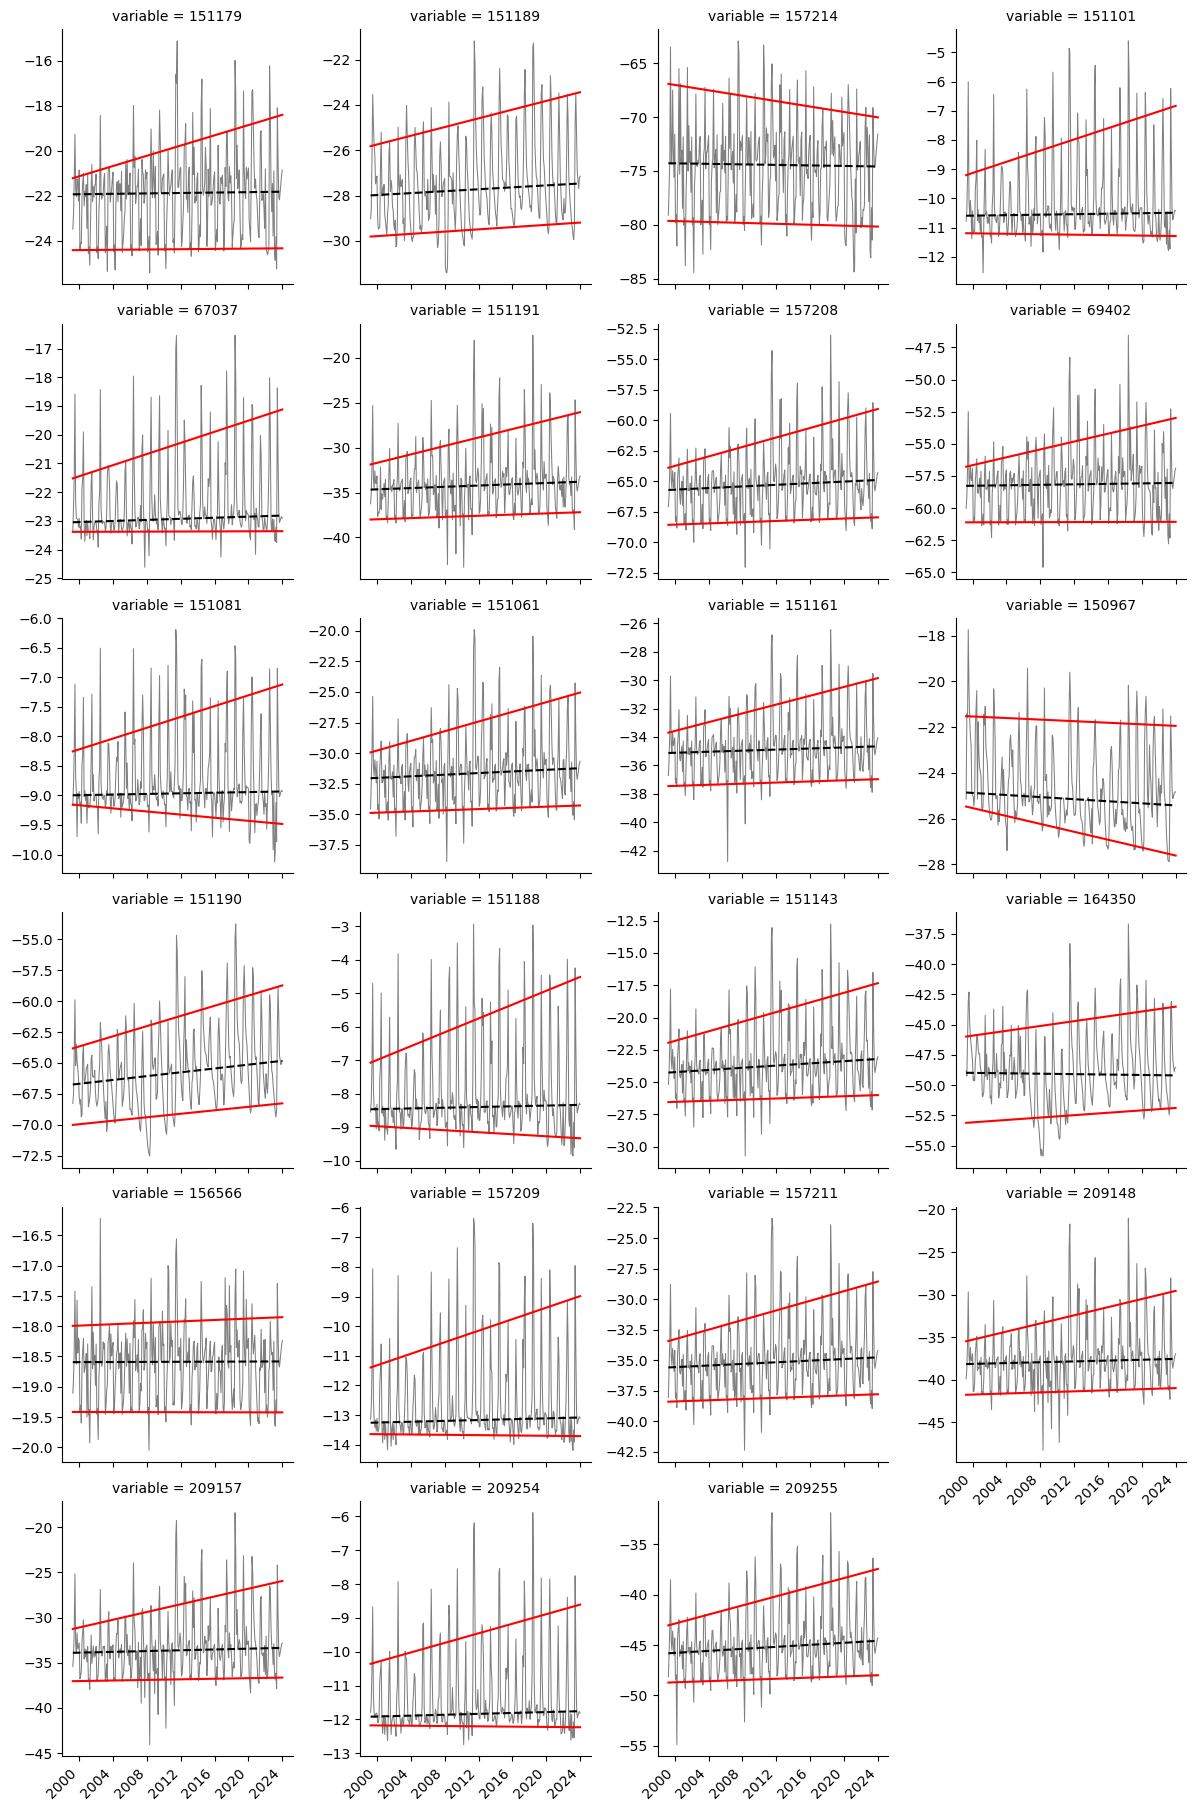

In [35]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(plot_data_and_quantreg)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

### Calculate slope of the quantile regressions

In [37]:
gwicids = df_trend['variable'].unique()
df_quantreg = pd.DataFrame(columns=['gwicid', 'quantreg_m1', 'quantreg_m9', 'quantreg_m5'])
for gwicid in gwicids:
    data = df_trend[df_trend['variable'] == gwicid]
    q1, q9, q5 = plot_data_and_quantreg(data, 'blue', quants=[0.1, 0.9], plot=False)
    m1, m9, m5 = q1.params.x, q9.params.x, q5.params.x
    new_data = [gwicid, m1, m9, m5]
    df_quantreg.loc[len(df_quantreg)] = new_data

/home/nick/miniforge3/envs/hydro/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



### Calculate correlation between slope and static variables

In [38]:
trends.index = trends.index.astype('int64')
df_stat = df_static.merge(trends, left_on='gwicid', right_index=True)
df_stat['gwicid'] = df_stat['gwicid'].astype(str)
df_stat = df_stat.merge(df_quantreg, left_on='gwicid', right_on='gwicid') 
corrmat = df_stat.corr()
corrslope = corrmat['slope']
corrslope

gwicid         0.218135
latitude      -0.217431
longitude      0.203067
altitude      -0.117698
total_dept     0.322984
swl            0.113154
cf_input      -0.222420
rs_input      -0.267250
gc_input      -0.319936
br_input      -0.222301
outlet         0.216070
ksat_r        -0.223325
intercept     -0.416643
slope          1.000000
p-value       -0.547900
quantreg_m1    0.878106
quantreg_m9    0.878804
quantreg_m5    0.944063
Name: slope, dtype: float64

### Plot slope on map

In [39]:
# Convert to GeoDataFrame
df_stat['geometry'] = [Point(xy) for xy in zip(df_stat.longitude, df_stat.latitude)]
gdf_stat = gpd.GeoDataFrame(df_stat, geometry='geometry', crs='EPSG:4326')

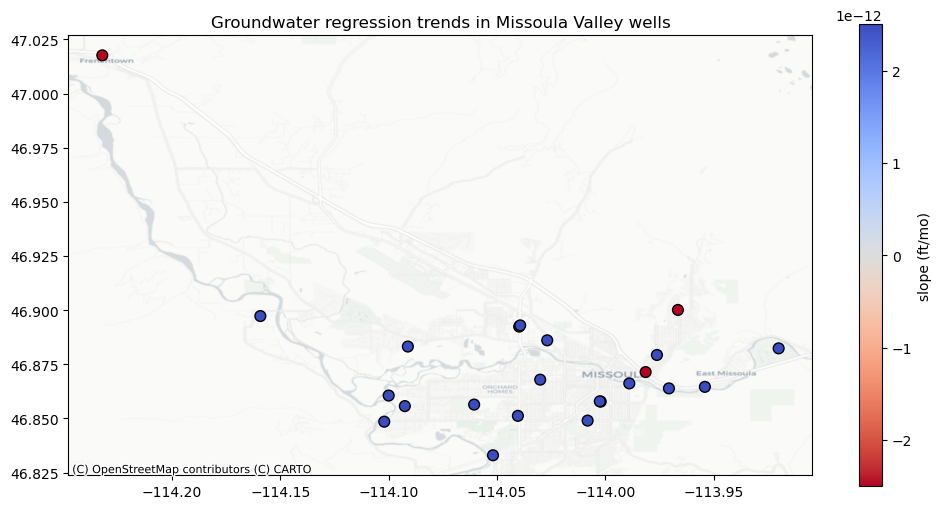

In [40]:
# Plot map of slope values
ax = gdf_stat.plot(figsize=(12, 6), 
                   column='slope', 
                   cmap='coolwarm_r', 
                   legend=True, 
                #    vmin=-2.5e-09, 
                #    vmax=2.5e-09,
                   vmin=-2.5e-12, 
                   vmax=2.5e-12,
                   edgecolor='black',
                   s=60)
ctx.add_basemap(ax, 
                crs=gdf_stat.crs, 
                source=ctx.providers.CartoDB.Positron,
                zoom=12)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('slope (ft/mo)')
ax.set_title('Groundwater regression trends in Missoula Valley wells')
# ax.set_axis_off()
plt.show()

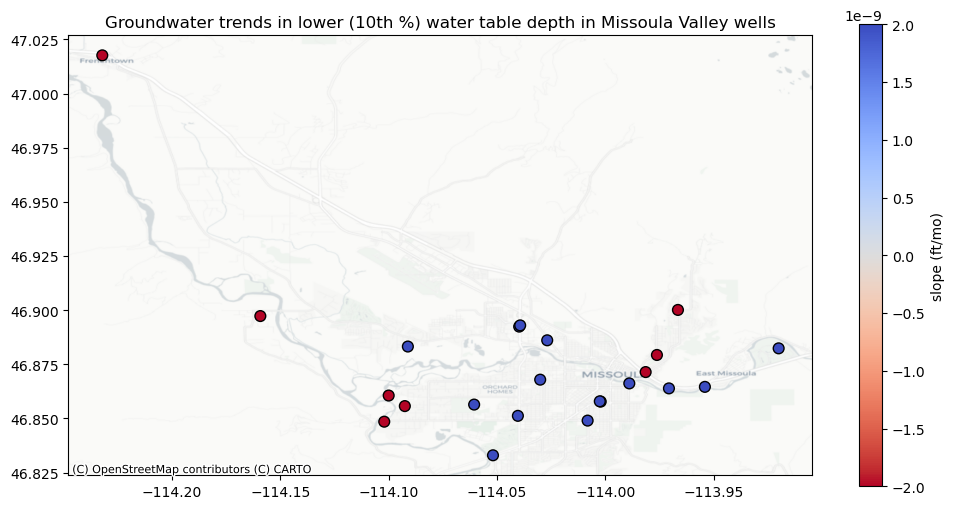

In [41]:
# Plot map of slope values
ax = gdf_stat.plot(figsize=(12, 6), 
                   column='quantreg_m1', 
                   cmap='coolwarm_r', 
                   legend=True, 
                   vmin=-0.000000002, 
                   vmax=0.000000002,
                   edgecolor='black',
                   s=60)
ctx.add_basemap(ax, 
                crs=gdf_stat.crs, 
                source=ctx.providers.CartoDB.Positron,
                zoom=12)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('slope (ft/mo)')
ax.set_title('Groundwater trends in lower (10th %) water table depth in Missoula Valley wells')
# ax.set_axis_off()
plt.show()

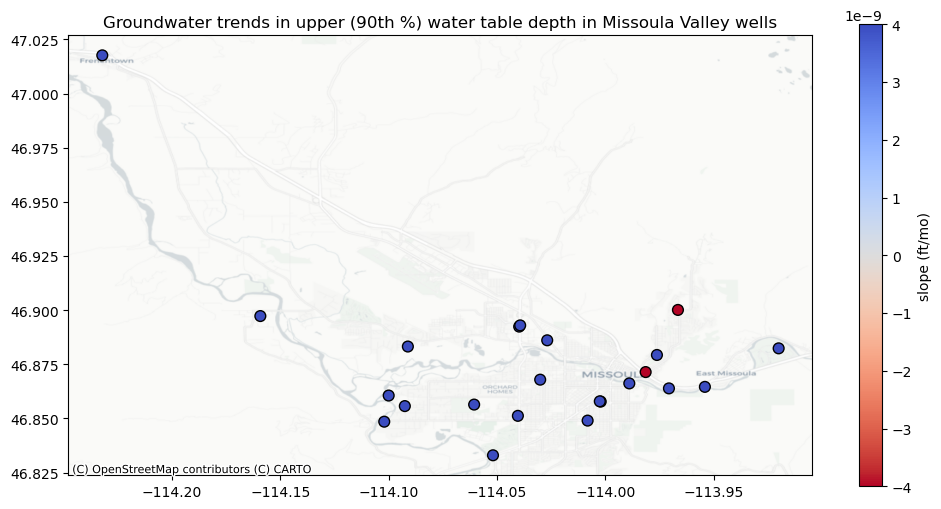

In [42]:
# Plot map of slope values
ax = gdf_stat.plot(figsize=(12, 6), 
                   column='quantreg_m9', 
                   cmap='coolwarm_r', 
                   legend=True, 
                   vmin=-0.000000004, 
                   vmax=0.000000004,
                   edgecolor='black',
                   s=60)
ctx.add_basemap(ax, 
                crs=gdf_stat.crs, 
                source=ctx.providers.CartoDB.Positron,
                zoom=12)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('slope (ft/mo)')
ax.set_title('Groundwater trends in upper (90th %) water table depth in Missoula Valley wells')
# ax.set_axis_off()
plt.show()

### Groundwater and City pumping analysis

In [13]:
gw = df_dyn.iloc[:, [0, 2]].dropna()

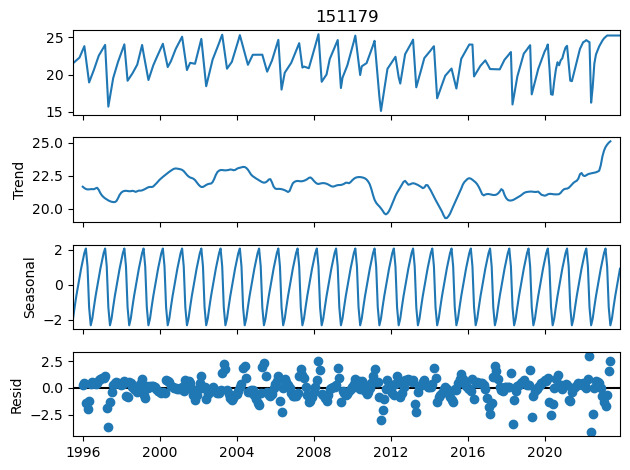

In [16]:
sm.tsa.seasonal_decompose(gw.iloc[:, 1], model='additive', period=12).plot()
plt.show()